# Dependências e Setup

In [1]:
DEPENDENCIES_PATH = "requirements.txt"

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import os
import math
import zipfile

import pandas as pd
import numpy as np

from scipy.sparse import issparse
from scipy.sparse.linalg import eigsh
from numpy.linalg import eigvals, norm

import matplotlib.pyplot as plt

import torch, platform
import torch
import torch.nn as nn

from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import gradcheck
from torch.utils.data import random_split
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
from itertools import product
from tqdm import tqdm
from typing import Callable, Dict, Any
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
print("Torch:", torch.__version__, "| MPS:", torch.mps.is_available(), "| Py:", platform.python_version())

Torch: 2.9.1 | MPS: True | Py: 3.13.10


In [5]:
with zipfile.ZipFile("./content/states_with_bounds.npz", 'r') as zf:
    print("Conteúdo:", zf.namelist())

Conteúdo: ['n_in.npy', 'P.npy', 'C.npy', 'data.npy', 'Nu.npy', 'n_eq.npy', 'q.npy', 'Nx.npy', 'n_con.npy', 'Nh.npy', 'u_hover.npy', 'U.npy']


In [6]:
DATA_PATH = './content/states_with_bounds.npz'
SEED      = 42

# Funções Utilitárias

In [7]:
def set_seed():
    random.seed(SEED); np.random.seed(SEED)
    torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setup

In [8]:
set_seed()

# Pré-processamento e Dataset

## Carregamento do Dataset

Carregando dados que definem o problema de otimização a ser resolvidos a partir do arquivo .npz de input. Pequenos checks de dimensões e de condições da matriz P são realizados.

In [9]:
class MPC_Problem:

    def __init__(self, np_raw_path):

      raw = np.load(DATA_PATH)

      # Dimensions
      self.n_states = int(raw["Nx"])
      self.n_actuations = int(raw["Nu"])
      self.n_horizon = int(raw["Nh"])
      self.dim_z = (self.n_states + self.n_actuations) * self.n_horizon

      # Constraints
      self.n_constraints =  int(raw["n_con"])
      self.n_eq_constraints = int(raw["n_eq"])
      self.n_ineq_constraints = int(raw["n_in"])
      
      # Iterating through data to extract each instance:
      # -> Decision variables, Duals and Bounds

      self.input_data = raw["data"].astype(np.float32)
      it_pos = 0

      self.state_list = self.input_data[:, it_pos: it_pos + self.n_states]
      it_pos += self.n_states
      
      self.z_list = self.input_data[:, it_pos : it_pos + self.dim_z]
      it_pos += self.dim_z

      self.raw_dual = self.input_data[:, it_pos : it_pos + self.n_constraints]
      it_pos += self.n_constraints

      self.lower_bounds = self.input_data[:, it_pos : it_pos + self.n_constraints]
      it_pos += self.n_constraints

      self.upper_bounds = self.input_data[:, it_pos : it_pos + self.n_constraints]

      # Quadratic Programming Matrices
      self.P = raw["P"].astype(np.float64)
      self.q = raw["q"].astype(np.float64)
      self.C = raw["C"].astype(np.float64)
      self.U = raw["U"].astype(np.float64)

      # Constraints Matrix
      self.D = np.concatenate((self.C,  self.U), axis=0)

      # Duals Extraction
      self.lamb = np.maximum(-self.raw_dual, 0)
      self.nu = np.maximum(self.raw_dual, 0)

      # Dimension Check
      assert self.P.shape == (self.dim_z, self.dim_z), f"P must be [{self.dim_z},{self.dim_z}], got {self.P.shape}"
      assert self.q.shape == (self.dim_z,), f"q must be [{self.dim_z}], got {self.q.shape}"
      assert self.C.shape == (self.n_eq_constraints, self.dim_z), f"C must be [{self.n_eq_constraints},{self.dim_z}], got {self.Q.shape}"
      assert self.U.shape == (self.n_ineq_constraints, self.dim_z), f"U must be [{self.n_ineq_constraints},{self.dim_z}], got {self.U.shape}"

      N_samples = self.input_data.shape[0]
      assert self.state_list.shape[0] == N_samples, f"state_list must have {N_samples} samples, got {self.state_list.shape[0]}"
      assert self.z_list.shape[0] == N_samples, f"z_list must have {N_samples} samples, got {self.z_list.shape[0]}"
      assert self.raw_dual.shape[0] == N_samples, f"raw_dual must have {N_samples} samples, got {self.raw_dual.shape[0]}"
      assert self.upper_bounds.shape[0] == N_samples, f"upper_bounds must have {N_samples} samples, got {self.upper_bounds.shape[0]}"
      assert self.lower_bounds.shape[0] == N_samples, f"lower_bounds must have {N_samples} samples, got {self.lower_bounds.shape[0]}"
      
      assert self.state_list.shape[1] == self.n_states, f"state_list must have {self.n_states} features, got {self.state_list.shape[1]}"
      assert self.z_list.shape[1] == self.dim_z, f"z_list must have {self.dim_z} features, got {self.z_list.shape[1]}"
      assert self.raw_dual.shape[1] == self.n_constraints, f"raw_lag must have {self.n_constraints} features, got {self.raw_lag.shape[1]}"
      assert self.upper_bounds.shape[1] == self.n_constraints, f"upper_bounds must have {self.n_constraints} features, got {self.upper_bounds.shape[1]}"
      assert self.lower_bounds.shape[1] == self.n_constraints, f"lower_bounds must have {self.n_constraints} features, got {self.lower_bounds.shape[1]}"

      total_expected_cols = self.n_states + self.dim_z  + self.n_constraints * 3
      assert self.input_data.shape[1] == total_expected_cols, f"Total input columns must be {total_expected_cols}, got {self.input_data.shape[1]}. Check slicing logic."
      print(f"[CHECK] - Dimensions and Sampling Ok")

      # P nature checking
      eigvals = np.linalg.eigvalsh(self.P)
      assert np.all(eigvals >= -1e-8), f"P not positive semidefinite, min eig = {eigvals.min()}"
      print(f"[CHECK] - P Matrices are Positive Semidefinite")
    
    def apply_primal_std(self):
      """
      t(z) -> z' | z' = z - mean / std
      """
      self.z_mean = self.z_list.mean(axis=0)
      self.z_std = self.z_list.std(axis=0)
      self.z_list = (self.z_list - self.z_mean) / self.z_std

      # This process must be applied to the constraints ineq:
      # a <= D z' <= b -> a <= D(mean) + (D @ diag(std)) z <= b
      # a' = a - D(mean) (same for b)
      # D' = D @ diag(std)

      self.lower_bounds = self.lower_bounds - self.D @ self.z_mean # Old D
      self.upper_bounds = self.upper_bounds - self.D @ self.z_mean # Old D
      self.D = self.D @ np.diag(self.z_std)
      
      # Ignoring P and q propagations of t
    
    def apply_state_std(self):
      """
      t(z) -> z' | z' = z - mean / std
      """

      self.state_mean = self.state_list.mean(axis=0)
      self.state_std = self.state_list.std(axis=0)
      self.state_list = (self.state_list - self.state_mean) / self.state_std
       

In [10]:
MPC = MPC_Problem(DATA_PATH)

[CHECK] - Dimensions and Sampling Ok
[CHECK] - P Matrices are Positive Semidefinite


In [11]:
MPC.apply_primal_std()
MPC.apply_state_std()

## Definindo DataClass do Pytorch

In [12]:
class MPC_DATASET(Dataset):

  def __init__(self, MPC):

    self.states = MPC.state_list
    self.decision_variables = MPC.z_list
    self.nu_lagrangians = MPC.nu
    self.lambda_lagrangians = MPC.lamb
    self.lower_bounds = MPC.lower_bounds
    self.upper_bounds = MPC.upper_bounds

    self.D = torch.from_numpy(MPC.D).float()

    # Pre-processing parameters

    # print(f"[CHECK] States list dimension: {self.states.shape}")
    # print(f"[CHECK] Decision Variables lis dimension: {self.decision_variables.shape}")
    # print(f"[CHECK] Nu Lagrangians dimension: {self.nu_lagrangians.shape}")
    # print(f"[CHECK] Lambda Lagrangians dimension: {self.lambda_lagrangians.shape}")

    # print(f"[CHECK] States list element list[i]: {self.states[0].shape}")
    # print(f"[CHECK] Decision Variables list element list[i]: {self.decision_variables[0].shape}")
    # print(f"[CHECK] Nu Lagrangians element list[i]: {self.nu_lagrangians[0].shape}")
    # print(f"[CHECK] Lambda Lagrangians element list[i]: {self.lambda_lagrangians[0].shape}")

  def __len__(self):
    return self.states.shape[0]

  def __getitem__(self, i):

    """
    Returning:
    -> x std
    -> z std
    -> z_inf
    -> z_sup
    """
    x = self.states[i]
    z = self.decision_variables[i]
    lb = self.lower_bounds[i]
    ub = self.upper_bounds[i]

    return {
        "x": torch.from_numpy(x).float(),
        "z": torch.from_numpy(z).float(),
        "lb": torch.from_numpy(lb).float(),
        "ub": torch.from_numpy(ub).float()
    }

# Função de Loss

In [13]:
class QPLoss(nn.Module):
    def __init__(self, D, lam=1e-4):
        """
        D : matriz de restrições (m, n) — fixa para todo o dataset
        lam : peso da penalização das violações
        """
        super().__init__()
        self.lam = lam
        
        self.register_buffer("D", D)

        self.primal_list = []
        self.penalty_list = []

    def visualize(self, show_total=True):
        """
        Plota a evolução dos termos da loss ao longo do treinamento.
        """

        if len(self.primal_list) == 0:
            print("Nenhum valor armazenado. Chame forward(..., store=True) durante o treino.")
            return

        plt.figure(figsize=(10, 5))

        plt.plot(self.primal_list, label="Primal (MSE)", linewidth=2)
        plt.plot(self.penalty_list, label=f"Penalty (λ * restrições)", linewidth=2)

        if show_total:
            total = [p + q for p, q in zip(self.primal_list, self.penalty_list)]
            plt.plot(total, label="Total Loss", linestyle="--", linewidth=2)

        plt.xlabel("Iterações de Treino")
        plt.ylabel("Valores")
        plt.title("Evolução dos termos da Loss QP")
        plt.legend()
        plt.grid(True)
        plt.show()

    def forward(self, z_pred, z_star, a, b, store=False):

        # 1. MSE
        mse = torch.mean((z_pred - z_star)**2)

        # 2. D no mesmo device que z_pred
        D = self.D.to(z_pred.device)
        Dz = z_pred @ D.T

        viol_sup = torch.relu(Dz - b)
        viol_inf = torch.relu(a - Dz)

        penalty = torch.mean(viol_sup**2 + viol_inf**2)

        loss = mse + self.lam * penalty

        if store:
            self.primal_list.append(mse.item())
            self.penalty_list.append((self.lam * penalty).item())

        return loss


## Validação da Loss

In [14]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")


########### SAMPLE 0 ############
[z_pred exemplo]: [ 1.926915    1.4872842   0.9007172  -2.1055214   0.67841846] ...
[z_opt exemplo]:  [ 1.0428772  -1.0048882  -1.0013796   1.0484915   0.44683602] ...

########### SAMPLE 1 ############
[z_pred exemplo]: [-0.2932438  -0.36662218 -1.6757499   0.24197184  1.6150508 ] ...
[z_opt exemplo]:  [-1.0100293  -1.0048879   1.0559524   1.0484914  -0.80759513] ...

########### SAMPLE 2 ############
[z_pred exemplo]: [-0.35967055  0.20261538 -0.98011136 -0.09841846 -0.0549707 ] ...
[z_opt exemplo]:  [-0.6306944   1.042594   -1.0013796  -1.0013233  -0.23146906] ...

########### SAMPLE 3 ############
[z_pred exemplo]: [ 1.2914786  -0.48302963 -1.3819302  -0.6833713  -2.0455623 ] ...
[z_opt exemplo]:  [-1.0100292 -1.0048879  1.0559522  0.5819848 -1.1607956] ...

########### SAMPLE 4 ############
[z_pred exemplo]: [-0.18580338 -0.4005565   0.4856711   1.1274276   0.54888463] ...
[z_opt exemplo]:  [-1.0100292 -1.0048879  1.0559522  1.0484914 -1.3487432]

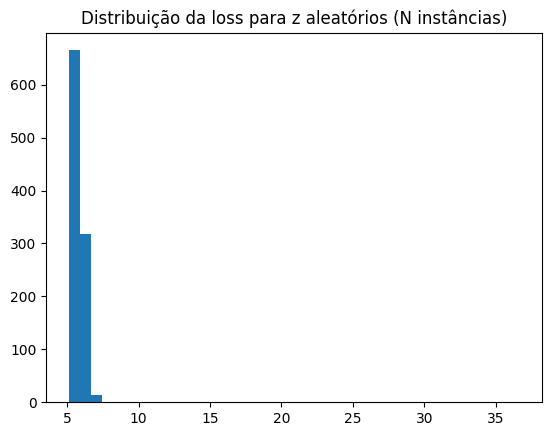

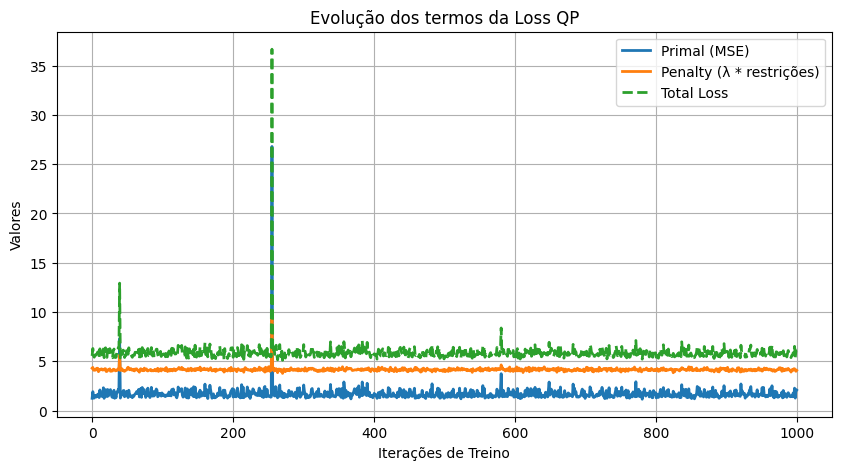

In [15]:

dataset = MPC_DATASET(MPC)
criterion = QPLoss(dataset.D, lam=1e-4).to(device)

def sample_random_z(batch, n, scale=1.0):
    return scale * torch.randn(batch, n)

loss_values = []
N = 1000

with torch.no_grad():
    for i in range(0, N):

        print(f"\n########### SAMPLE {i} ############")

        sample = dataset[i]
        z_opt = sample["z"].to(device)      # shape (n,)
        lb    = sample["lb"].to(device)     # shape (m,)
        ub    = sample["ub"].to(device)     # shape (m,)

        # --- garante batch = 1 de forma segura ---
        z_opt = z_opt.unsqueeze(0)          # shape (1, n)
        lb    = lb.unsqueeze(0)             # shape (1, m)
        ub    = ub.unsqueeze(0)             # shape (1, m)

        # --- gera 64 candidatos aleatórios ---
        z_rand = sample_random_z(batch=64, n=z_opt.shape[1]).to(device)

        # Mostra apenas o primeiro elemento do batch
        print(f"[z_pred exemplo]: {z_rand[0, :5].cpu().numpy()} ...")
        print(f"[z_opt exemplo]:  {z_opt[0, :5].cpu().numpy()} ...")

        # Computa loss
        loss = criterion(z_rand, z_opt, lb, ub, store=True)
        loss_values.append(loss.item())

# --- Histograma ---
plt.hist(loss_values, bins=40)
plt.title(f"Distribuição da loss para z aleatórios (N instâncias)")
plt.show()

criterion.visualize()



=== Teste: Loss no ótimo ===
Média  : 8.113331e-15
Máximo : 7.333266e-11
Mínimo : 8.466148e-19


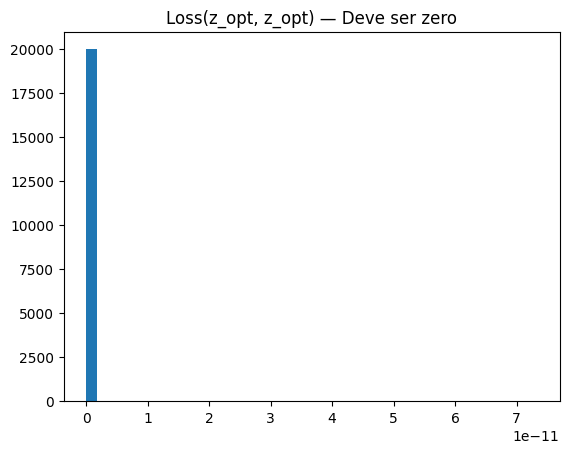

In [16]:
def test_loss_zero_at_optimum(criterion, dataset, device):
    zero_losses = []

    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            z_opt = sample["z"].to(device).unsqueeze(0)
            lb    = sample["lb"].to(device).unsqueeze(0)
            ub    = sample["ub"].to(device).unsqueeze(0)

            # loss no ótimo
            loss = criterion(z_opt, z_opt, lb, ub).item()
            zero_losses.append(loss)

    print("\n=== Teste: Loss no ótimo ===")
    print(f"Média  : {sum(zero_losses)/len(zero_losses):.6e}")
    print(f"Máximo : {max(zero_losses):.6e}")
    print(f"Mínimo : {min(zero_losses):.6e}")

    plt.hist(zero_losses, bins=40)
    plt.title("Loss(z_opt, z_opt) — Deve ser zero")
    plt.show()

dataset = MPC_DATASET(MPC)
criterion = QPLoss(dataset.D).to(device)
test_loss_zero_at_optimum(criterion, dataset, device)

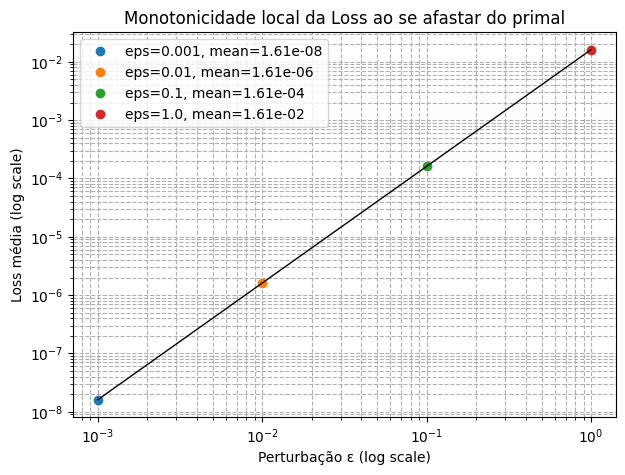

In [17]:
def test_local_curvature(criterion, dataset, device, epsilons=None):
    if epsilons is None:
        epsilons = [1e-3, 1e-2, 1e-1, 1.0]

    losses_per_eps = {eps: [] for eps in epsilons}

    with torch.no_grad():
        for i in range(10000):
            sample = dataset[i]
            z_opt = sample["z"].to(device).unsqueeze(0)
            lb    = sample["lb"].to(device).unsqueeze(0)
            ub    = sample["ub"].to(device).unsqueeze(0)

            n = z_opt.shape[1]

            direction = torch.randn(1, n).to(device)
            direction = direction / (torch.norm(direction) + 1e-9)

            for eps in epsilons:
                z_test = z_opt + eps * direction
                loss = criterion(z_test, z_opt, lb, ub).item()
                losses_per_eps[eps].append(loss)

    # Plot
    plt.figure(figsize=(7,5))
    mean_losses = []

    for eps in epsilons:
        mean_loss = sum(losses_per_eps[eps]) / len(losses_per_eps[eps])
        mean_losses.append(mean_loss)
        plt.plot([eps], [mean_loss], "o", label=f"eps={eps}, mean={mean_loss:.2e}")

    plt.plot(epsilons, mean_losses, "-k", linewidth=1)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Perturbação ε (log scale)")
    plt.ylabel("Loss média (log scale)")
    plt.title("Monotonicidade local da Loss ao se afastar do primal")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


dataset = MPC_DATASET(MPC)
criterion = QPLoss(dataset.D).to(device)
test_local_curvature(criterion, dataset, device)


=== Teste de Gradiente no Ótimo ===
Normas dos gradientes: [2.2001380e-10 4.0696072e-10 3.6135628e-10 ... 1.3894198e-09 3.4184033e-10
 6.0845007e-10]


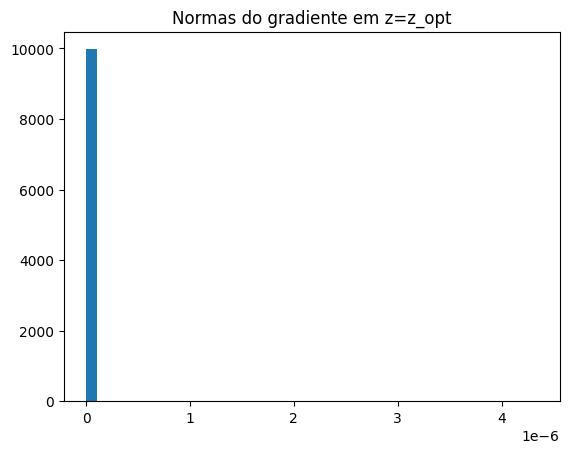

In [18]:
def test_gradient_stability(criterion, dataset, device):
    grads = []

    for i in range(10000):
        sample = dataset[i]

        z_opt = sample["z"].to(device).unsqueeze(0).detach().clone()
        lb = sample["lb"].to(device).unsqueeze(0)
        ub = sample["ub"].to(device).unsqueeze(0)

        z_opt.requires_grad_(True)

        loss = criterion(z_opt, z_opt, lb, ub)
        loss.backward()

        grads.append(z_opt.grad.detach().cpu().numpy())

    grads = np.array(grads)
    grad_norms = np.linalg.norm(grads.reshape(grads.shape[0], -1), axis=1)

    print("\n=== Teste de Gradiente no Ótimo ===")
    print("Normas dos gradientes:", grad_norms)

    plt.hist(grad_norms, bins=40)
    plt.title("Normas do gradiente em z=z_opt")
    plt.show()

dataset = MPC_DATASET(MPC)
criterion = QPLoss(dataset.D).to(device)
test_gradient_stability(criterion, dataset, device)

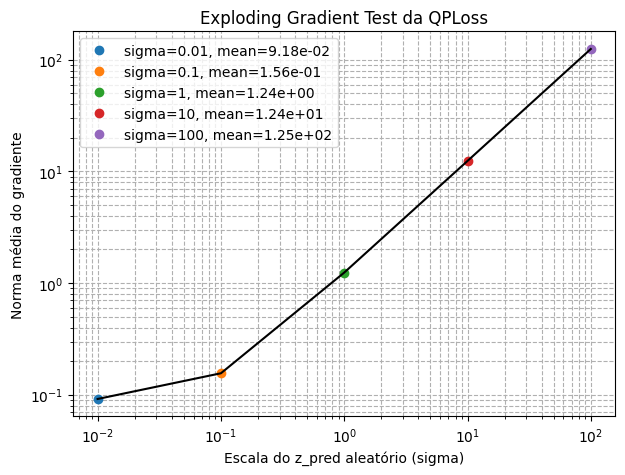

In [19]:
def test_gradient_explosion(criterion, dataset, device, sigmas=None):
    if sigmas is None:
        sigmas = [1e-2, 1e-1, 1, 10, 100]

    grad_norms_by_sigma = {s: [] for s in sigmas}

    for i in range(1000):
        sample = dataset[i]
        z_opt = sample["z"].to(device).unsqueeze(0)
        lb    = sample["lb"].to(device).unsqueeze(0)
        ub    = sample["ub"].to(device).unsqueeze(0)

        n = z_opt.shape[1]

        for sigma in sigmas:
            # cria z_pred aleatório com variância controlada
            z_pred = (sigma * torch.randn(1, n)).to(device)
            z_pred.requires_grad_(True)

            loss = criterion(z_pred, z_opt, lb, ub)
            loss.backward()

            grad = z_pred.grad.detach()
            grad_norm = torch.norm(grad).item()

            grad_norms_by_sigma[sigma].append(grad_norm)

    # ---- Plot ----
    plt.figure(figsize=(7,5))

    means = []
    for sigma in sigmas:
        mean_norm = sum(grad_norms_by_sigma[sigma]) / len(grad_norms_by_sigma[sigma])
        means.append(mean_norm)
        plt.plot(sigma, mean_norm, "o", label=f"sigma={sigma}, mean={mean_norm:.2e}")

    plt.plot(sigmas, means, "-k")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Escala do z_pred aleatório (sigma)")
    plt.ylabel("Norma média do gradiente")
    plt.title("Exploding Gradient Test da QPLoss")
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

dataset = MPC_DATASET(MPC)
criterion = QPLoss(dataset.D).to(device)
test_gradient_explosion(criterion, dataset, device)

# 3. Definição da Rede

In [20]:
class PlannerNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden=(64, 64)):

        super().__init__()
        layers = []
        prev = input_dim

        for h in hidden:
            linear = nn.Linear(prev, h)
            nn.init.xavier_uniform_(linear.weight,
                                    gain=nn.init.calculate_gain("relu"))
            nn.init.zeros_(linear.bias)
            layers += [linear, nn.ReLU()]
            prev = h

        out = nn.Linear(prev, output_dim)
        nn.init.xavier_uniform_(out.weight,
                                gain=1.0)
        nn.init.zeros_(out.bias)

        layers.append(out)
        self.net = nn.Sequential(*layers)

    def forward(self, x_std):
        return self.net(x_std)

# 4. Treinamento

## Treinamento Exploratório

In [21]:
def grad_norm(model):
    """Computa ||g||_2 global."""
    total = 0
    for p in model.parameters():
        if p.grad is not None:
            total += p.grad.detach().norm(2).item()**2
    return total**0.5


def grad_direction(model, prev_grad):
    """
    Direção do gradiente = cosseno entre step atual e anterior.
    prev_grad: vetor 1D com todos os gradientes do passo anterior.
    """
    # grad atual
    g = []
    for p in model.parameters():
        if p.grad is not None:
            g.append(p.grad.detach().flatten())
    g = torch.cat(g)

    if prev_grad is None:
        return None, g  # sem direção para o 1º passo

    cos = torch.nn.functional.cosine_similarity(g, prev_grad, dim=0).item()
    return cos, g

@torch.no_grad()
def evaluate_model(model, loss_fn, loader, device="cpu"):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            x = batch["x"].to(device)
            z = batch["z"].to(device)
            lb = batch["lb"].to(device)
            ub = batch["ub"].to(device)

            z_pred = model(x)
            loss = loss_fn(z_pred, z, lb, ub, store=False)

            total_loss += loss.item()

    return total_loss / len(loader)

def plot_training_history(history):

    fig, axs = plt.subplots(3, 1, figsize=(10, 14))

    # --- Loss Treino/Teste ---
    axs[0].plot(history["train_loss"], label="Train Loss", linewidth=2)
    axs[0].plot(history["val_loss"], label="Val Loss", linewidth=2)
    axs[0].set_title("Loss no Treino e Teste")
    axs[0].set_xlabel("Época")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)
    axs[0].legend()

    # --- Norma do Gradiente ---
    axs[1].plot(history["grad_norm"], label="Norma do Gradiente")
    axs[1].set_title("Norma do Gradiente ao Longo do Tempo")
    axs[1].set_xlabel("Iteração")
    axs[1].set_ylabel("||g||")
    axs[1].grid(True)

    # --- Direção do Gradiente ---
    axs[2].plot(history["grad_cosine"], label="Cosine Similarity", color="green")
    axs[2].set_title("Direção do Gradiente (similaridade coseno)")
    axs[2].set_xlabel("Iteração")
    axs[2].set_ylabel("cos(g_t, g_{t-1})")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

def train_model(
    model,
    loss_fn,
    train_loader,
    val_loader,
    optimizer,
    epochs=50,
    device="cpu",
    patience=75,        # quantas epochs sem melhora esperar
    min_delta=1e-6     # mínima melhora para considerar como progresso
):
    model.to(device)
    history = {
        "train_loss": [],
        "val_loss": [],
        "grad_norm": [],
        "grad_cosine": []
    }

    prev_grad = None
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for batch in train_loader:
            x = batch["x"].to(device)
            z = batch["z"].to(device)
            lb = batch["lb"].to(device)
            ub = batch["ub"].to(device)

            optimizer.zero_grad()
            z_pred = model(x)
            loss = loss_fn(z_pred, z, lb, ub, store=True)
            loss.backward()

            # --- Compute gradient norm ---
            grad_vec = torch.cat([
                p.grad.reshape(-1) for p in model.parameters() if p.grad is not None
            ])
            grad_norm = grad_vec.norm().item()
            history["grad_norm"].append(grad_norm)

            # --- Compute gradient direction (cosine similarity) ---
            if prev_grad is not None:
                cosine = torch.nn.functional.cosine_similarity(
                    grad_vec, prev_grad, dim=0
                ).item()
            else:
                cosine = 1.0
            history["grad_cosine"].append(cosine)
            prev_grad = grad_vec.detach()

            optimizer.step()
            epoch_loss += loss.item()

        # Média da loss do epoch
        epoch_loss /= len(train_loader)
        history["train_loss"].append(epoch_loss)

        # Avaliação no conjunto de validação
        val_loss = evaluate_model(model, loss_fn, val_loader, device)
        history["val_loss"].append(val_loss)

        print(
            f"[Epoch {epoch+1:03d}] "
            f"Train Loss = {epoch_loss:.6f} | "
            f"Val Loss = {val_loss:.6f} | "
            f"Grad Norm = {grad_norm:.3e} | "
            f"Cosine Dir = {cosine:.3f}"
        )

        # --- Early Stopping ---
        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # opcional: salvar melhor modelo
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping ativado após {epoch+1} epochs sem melhora.\n")
                model.load_state_dict(best_model_state)  # retorna ao melhor modelo
                break

    print("\nTreino finalizado! Gerando gráficos...\n")
    plot_training_history(history)

    print("\nGerando gráficos específicos da QPLoss...")
    loss_fn.visualize(show_total=True)

    return history


In [22]:
device = torch.device("mps")

DATASET = MPC_DATASET(MPC)

train_size = int(0.8 * len(DATASET))
val_size   = len(DATASET) - train_size

train_dataset, val_dataset = random_split(DATASET, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset,  batch_size=256, shuffle=False)

model = PlannerNet(MPC.n_states, MPC.dim_z)
loss_fn = QPLoss(DATASET.D)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

history = train_model(
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    epochs=200,
    device=device
)

[Epoch 001] Train Loss = 1.091525 | Val Loss = 0.794803 | Grad Norm = 1.380e-01 | Cosine Dir = 0.836
[Epoch 002] Train Loss = 0.825584 | Val Loss = 0.709866 | Grad Norm = 3.717e-01 | Cosine Dir = 0.172
[Epoch 003] Train Loss = 0.697352 | Val Loss = 0.668857 | Grad Norm = 8.596e-01 | Cosine Dir = 0.231
[Epoch 004] Train Loss = 0.596600 | Val Loss = 0.642225 | Grad Norm = 5.557e-02 | Cosine Dir = 0.265
[Epoch 005] Train Loss = 0.571864 | Val Loss = 0.637211 | Grad Norm = 1.168e-01 | Cosine Dir = 0.839
[Epoch 006] Train Loss = 0.527866 | Val Loss = 0.614598 | Grad Norm = 2.902e+01 | Cosine Dir = 0.083
[Epoch 007] Train Loss = 0.549704 | Val Loss = 0.696227 | Grad Norm = 6.186e-01 | Cosine Dir = 0.988
[Epoch 008] Train Loss = 0.575174 | Val Loss = 0.610357 | Grad Norm = 2.449e-01 | Cosine Dir = 0.955
[Epoch 009] Train Loss = 0.510594 | Val Loss = 0.577976 | Grad Norm = 5.776e-02 | Cosine Dir = 0.146
[Epoch 010] Train Loss = 0.446991 | Val Loss = 0.565347 | Grad Norm = 5.408e-02 | Cosine Di

KeyboardInterrupt: 

## Estimando Melhor Modelo

### Treinamento Parametrizado com K-Folding e Early Stopping

In [ ]:
def train_one_epoch(model, loss_fn, loader, optimizer, device, clip_value=None, store_loss=False):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for batch in loader:
        x = batch["x"].to(device)
        z = batch["z"].to(device)
        lb = batch["lb"].to(device)
        ub = batch["ub"].to(device)

        optimizer.zero_grad()
        z_pred = model(x)
        loss = loss_fn(z_pred, z, lb, ub, store=store_loss)
        loss.backward()

        if clip_value is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(1, n_batches)


@torch.no_grad()
def evaluate(model, loss_fn, loader, device):
    model.eval()
    running_loss = 0.0
    n_batches = 0

    for batch in loader:
        x = batch["x"].to(device)
        z = batch["z"].to(device)
        lb = batch["lb"].to(device)
        ub = batch["ub"].to(device)

        z_pred = model(x)
        loss = loss_fn(z_pred, z, lb, ub, store=False)
        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(1, n_batches)


from tqdm import tqdm

def k_fold_train(
    dataset,
    model_fn: Callable[[], torch.nn.Module],
    loss_fn_fn: Callable[[], torch.nn.Module],
    k: int = 5,
    num_epochs: int = 100,
    batch_size: int = 256,
    lr: float = 3e-4,
    weight_decay: float = 1e-5,
    device: str = None,
    patience: int = 100,
    min_delta: float = 1e-6,
    clip_value: float = 1.0,
    verbose: bool = True,
    use_tqdm_folds: bool = True,
    use_tqdm_epochs: bool = False
) -> Dict[str, Any]:

    if device is None:
        device = "mps" if torch.mps.is_available() else "cpu"

    n = len(dataset)
    indices = np.arange(n)
    rng = np.random.RandomState(SEED)
    rng.shuffle(indices)

    # Compute fold sizes
    fold_sizes = np.full(k, n // k, dtype=int)
    fold_sizes[: n % k] += 1
    current = 0

    all_fold_histories = []
    best_model_states = []

    # -----------------------
    # Setup tqdm for FOLDS
    # -----------------------
    fold_range = range(k)
    if use_tqdm_folds:
        fold_range = tqdm(range(k), desc="K-Fold", leave=False)

    for fold in fold_range:

        start, stop = current, current + fold_sizes[fold]
        val_idx = indices[start:stop]
        train_idx = np.setdiff1d(indices, val_idx)
        current = stop

        train_subset = Subset(dataset, train_idx.tolist())
        val_subset = Subset(dataset, val_idx.tolist())

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_fn().to(device)
        loss_fn = loss_fn_fn()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_val = float("inf")
        best_state = None
        patience_counter = 0

        history = {"train_loss": [], "val_loss": []}

        if verbose and not use_tqdm_folds:
            print(f"\n=== Fold {fold+1}/{k} | train {len(train_idx)} samples | val {len(val_idx)} samples ===")

        # -----------------------
        # tqdm for EPOCHS
        # -----------------------
        epoch_range = range(1, num_epochs + 1)
        if use_tqdm_epochs:
            epoch_range = tqdm(epoch_range, desc=f"Fold {fold+1}", leave=False)

        for epoch in epoch_range:
            train_loss = train_one_epoch(
                model, loss_fn, train_loader, optimizer,
                device, clip_value=clip_value, store_loss=True
            )

            val_loss = evaluate(model, loss_fn, val_loader, device)

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)

            if verbose and not use_tqdm_epochs:
                print(
                    f"Fold {fold+1} | Epoch {epoch:03d} "
                    f"| Train {train_loss:.6f} | Val {val_loss:.6f} | Best {best_val:.6f}"
                )

            # early stopping
            if val_loss + min_delta < best_val:
                best_val = val_loss
                best_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping on fold {fold+1} at epoch {epoch}.")
                break

        all_fold_histories.append(history)
        best_model_states.append({
            "fold": fold,
            "best_val_loss": best_val,
            "state_dict": best_state
        })

    result = {
        "fold_histories": all_fold_histories,
        "best_models": best_model_states,
        "params": {
            "k": k,
            "num_epochs": num_epochs,
            "batch_size": batch_size,
            "lr": lr,
            "weight_decay": weight_decay,
            "patience": patience,
            "clip_value": clip_value
        }
    }

    return result


### Search

In [ ]:
def generate_param_combinations(param_grid):
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    for combo in product(*values):
        params = dict(zip(keys, combo))
        yield params
        
def grid_search(param_grid, k=5, num_epochs=300):

    all_results = []
    best_result = None
    best_avg_val_loss = float("inf")

    def mean_best_val_loss(result):
        fold_histories = result["fold_histories"]
        best_vals = [min(f["val_loss"]) for f in fold_histories]
        return sum(best_vals) / len(best_vals)

    param_combinations = list(generate_param_combinations(param_grid))

    print(f"\n=== Iniciando Grid Search com {len(param_combinations)} combinações ===\n")

    for params in tqdm(param_combinations, desc="Grid Search"):

        dataset = MPC_DATASET(MPC)

        result = k_fold_train(
            dataset=dataset,
            model_fn=lambda : PlannerNet(
                MPC.n_states,
                MPC.dim_z,
                (params["hidden_dim"], params["hidden_dim"])
            ),
            loss_fn_fn=lambda : QPLoss(dataset.D),
            k=k,
            num_epochs=num_epochs,
            batch_size=params["batch_size"],
            lr=params["lr"],
            weight_decay=params["weight_decay"],
            patience=75,
            min_delta=1e-6,
            clip_value=1.0,
            verbose=True,
            use_tqdm_folds=False
        )

        avg_val = mean_best_val_loss(result)

        tqdm.write(f"Params={params} | Média da Val Loss={avg_val:.6f}")

        entry = {"params": params, "result": result}
        all_results.append(entry)

        if avg_val < best_avg_val_loss:
            best_avg_val_loss = avg_val
            best_result = entry

    return {
        "all_results": all_results,
        "best_result": best_result,
        "best_val_loss": best_avg_val_loss
    }


In [ ]:
param_grid = {
    "hidden_dim": [32, 64, 128],
    "lr": [1e-3, 5e-4, 1e-4],
    "batch_size": [32, 64, 128],
    "weight_decay": [0.0, 1e-5],
}

grid_search_result = grid_search(param_grid)


=== Iniciando Grid Search com 54 combinações ===



Grid Search:   0%|          | 0/54 [00:00<?, ?it/s]


=== Fold 1/5 | train 16000 samples | val 4000 samples ===
Fold 1 | Epoch 001 | Train 0.794220 | Val 1.252221 | Best inf
Fold 1 | Epoch 002 | Train 0.625830 | Val 1.024953 | Best 1.252221
Fold 1 | Epoch 003 | Train 0.550014 | Val 0.943682 | Best 1.024953
Fold 1 | Epoch 004 | Train 0.507366 | Val 1.054651 | Best 0.943682
Fold 1 | Epoch 005 | Train 0.495187 | Val 0.922766 | Best 0.943682
Fold 1 | Epoch 006 | Train 0.457419 | Val 0.867172 | Best 0.922766
Fold 1 | Epoch 007 | Train 0.469022 | Val 0.923103 | Best 0.867172
Fold 1 | Epoch 008 | Train 0.432318 | Val 0.921816 | Best 0.867172
Fold 1 | Epoch 009 | Train 0.449111 | Val 0.952665 | Best 0.867172
Fold 1 | Epoch 010 | Train 0.486328 | Val 0.892175 | Best 0.867172
Fold 1 | Epoch 011 | Train 0.439078 | Val 0.962600 | Best 0.867172
Fold 1 | Epoch 012 | Train 0.444655 | Val 1.157259 | Best 0.867172
Fold 1 | Epoch 013 | Train 0.457828 | Val 1.151695 | Best 0.867172
Fold 1 | Epoch 014 | Train 0.488721 | Val 1.269505 | Best 0.867172
Fold 1 |

Grid Search:   2%|▏         | 1/54 [1:23:54<74:06:43, 5034.03s/it]

Fold 5 | Epoch 300 | Train 0.128044 | Val 0.065101 | Best 0.064713
Params={'hidden_dim': 32, 'lr': 0.001, 'batch_size': 32, 'weight_decay': 0.0} | Média da Val Loss=0.116959

=== Fold 1/5 | train 16000 samples | val 4000 samples ===
Fold 1 | Epoch 001 | Train 0.795308 | Val 1.225110 | Best inf
Fold 1 | Epoch 002 | Train 0.617914 | Val 1.095198 | Best 1.225110
Fold 1 | Epoch 003 | Train 0.554789 | Val 0.937553 | Best 1.095198
Fold 1 | Epoch 004 | Train 0.494215 | Val 0.919003 | Best 0.937553
Fold 1 | Epoch 005 | Train 0.479169 | Val 0.867504 | Best 0.919003
Fold 1 | Epoch 006 | Train 0.460150 | Val 0.804694 | Best 0.867504
Fold 1 | Epoch 007 | Train 0.499380 | Val 0.836815 | Best 0.804694
Fold 1 | Epoch 008 | Train 0.476736 | Val 0.904499 | Best 0.804694
Fold 1 | Epoch 009 | Train 0.471924 | Val 1.283476 | Best 0.804694
Fold 1 | Epoch 010 | Train 0.522441 | Val 1.179850 | Best 0.804694
Fold 1 | Epoch 011 | Train 0.487544 | Val 1.429636 | Best 0.804694
Fold 1 | Epoch 012 | Train 0.497860

Grid Search:   2%|▏         | 1/54 [1:49:38<96:50:56, 6578.42s/it]


KeyboardInterrupt: 

## Treinamento Final

In [ ]:
print(grid_search_result["best_result"]["params"])

NameError: name 'grid_search_result' is not defined

: 

: 

: 

: 

In [ ]:
print(grid_search_result["all_results"])

[{'params': {'hidden_dim': 32, 'lr': 0.001, 'batch_size': 32, 'weight_decay': 0.0}, 'result': {'fold_histories': [{'train_loss': [0.813138743519783, 0.628131493896246, 0.5678269573450089, 0.5174550768136978, 0.4484716982841492, 0.47776250141859056, 0.4638231190741062, 0.4782991164624691, 0.5318386119902134, 0.47920793446898463, 0.5517350950539112, 0.5225830809175969, 0.5552525728046894, 0.5617248448729515, 0.6604215906262397, 0.6444215922951698, 0.6525188111364841, 0.5606283640861511, 0.5875382415950299, 0.47796569284796714, 0.42057787579298017, 0.43086105862259866, 0.38544619709253314, 0.38477551755309103, 0.33589648416638374, 0.3169016543030739, 0.30520476526021956, 0.3731744347214699, 0.31972223438322545, 0.28365837267041205, 0.29656029903888703, 0.25066365738213064, 0.2694593667089939, 0.33256722083687784, 0.2812592311948538, 0.29879501451551915, 0.3538209448903799, 0.32065740498900414, 0.30070841701328754, 0.24838235075771808, 0.22742828740179538, 0.2127358858138323, 0.28221162758

: 

: 

: 

: 

In [ ]:
device = torch.device("mps")
DATASET = MPC_DATASET(MPC)

params = grid_search_result["best_result"]["params"]

train_size = int(0.8 * len(DATASET))
val_size   = len(DATASET) - train_size

train_dataset, val_dataset = random_split(DATASET, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader   = DataLoader(val_dataset,  batch_size=params["batch_size"], shuffle=False)

model = PlannerNet(MPC.n_states, MPC.dim_z, (params["hidden_dim"], params["hidden_dim"]))
loss_fn = QPLoss(DATASET.D)

optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

history = train_model(
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    epochs=300,
    device=device
)

NameError: name 'grid_search_result' is not defined

: 

: 

: 

: 

Mean Validation Loss: 0.1116


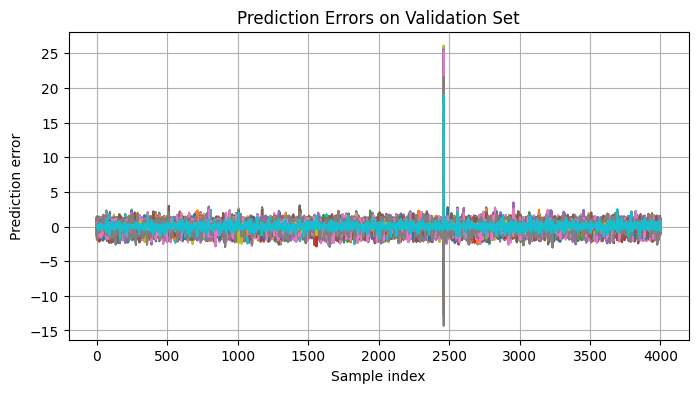

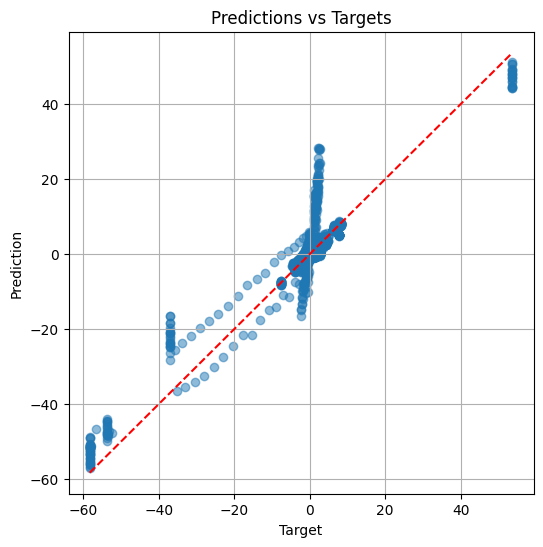

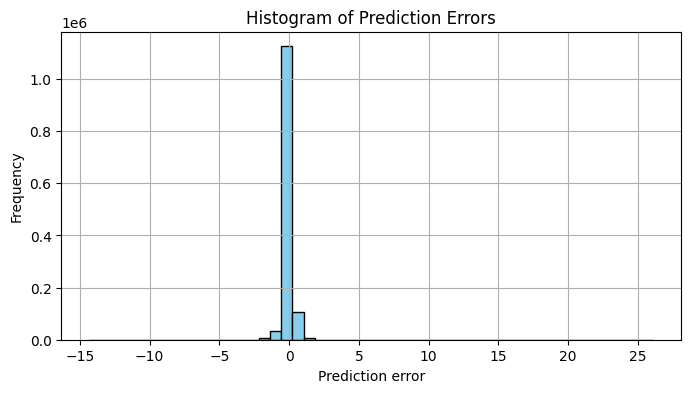

MSE: 0.1027, MAE: 0.1296, R2: 0.8904


: 

: 

: 

: 

In [ ]:
model.eval()
val_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in val_loader:
        x = batch["x"].to(device)
        z = batch["z"].to(device)   # alvo
        # Se houver limites:
        lb = batch["lb"].to(device)
        ub = batch["ub"].to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, z, lb, ub)  # adapte para sua loss
        val_loss += loss.item() * x.size(0)

        all_preds.append(y_pred.cpu().numpy())
        all_targets.append(z.cpu().numpy())

val_loss /= len(val_dataset)
print(f"Mean Validation Loss: {val_loss:.4f}")

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(all_targets, all_preds)
mae = mean_absolute_error(all_targets, all_preds)
r2  = r2_score(all_targets, all_preds)

errors = all_preds - all_targets
import matplotlib.pyplot as plt

# --- Erro ao longo das amostras ---
plt.figure(figsize=(8,4))
plt.plot(errors)
plt.xlabel("Sample index")
plt.ylabel("Prediction error")
plt.title("Prediction Errors on Validation Set")
plt.grid(True)
plt.show()

# --- Scatter plot: Predição vs Alvo ---
plt.figure(figsize=(6,6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title("Predictions vs Targets")
plt.grid(True)
plt.show()

# --- Histograma dos erros ---

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
errors = all_preds - all_targets
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Prediction error")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.grid(True)
plt.show()

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


: 

: 

: 

: 

In [ ]:
import pickle

with open("estado_completo.pkl", "wb") as f:
    pickle.dump(globals(), f)